**What is this?**


*This jupyter notebook is part of a collection of notebooks on various topics discussed during the Time Domain Astrophysics course delivered by Stefano Covino at the [Università dell'Insubria](https://www.uninsubria.eu/) in Como (Italy). Please direct questions and suggestions to [stefano.covino@inaf.it](mailto:stefano.covino@inaf.it).*

**This is a `Python` notebook**

![Time Domain Astrophysics](Pics/TimeDomainBanner.jpg)

# Non-parametric periodograms 
***

We computed a few different periodograms based on non-parametric methods as implemented in the [P4J library](https://github.com/phuijse/P4J) by [Pablo Huijse](mailto:pablo.huijse0gmail.com) et al.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from astropy.timeseries import LombScargle
import P4J
print("P4J version:")
print(P4J.__version__)

P4J version:
1.0.0


## Generating a simple synthetic light curve
***

- Let's start creating an irregulary sampled time series using a harmonic model composed of three sine waves with an specified Signal to Noise Ratio S/N ratio. 
    - We choose "$2.0$" as fudamental frequency, and produce a monitoring of "$100.0$", inverse units of the frequency, with $30$ points.
    
- And let's give a look at the light-curve and at the folded version.

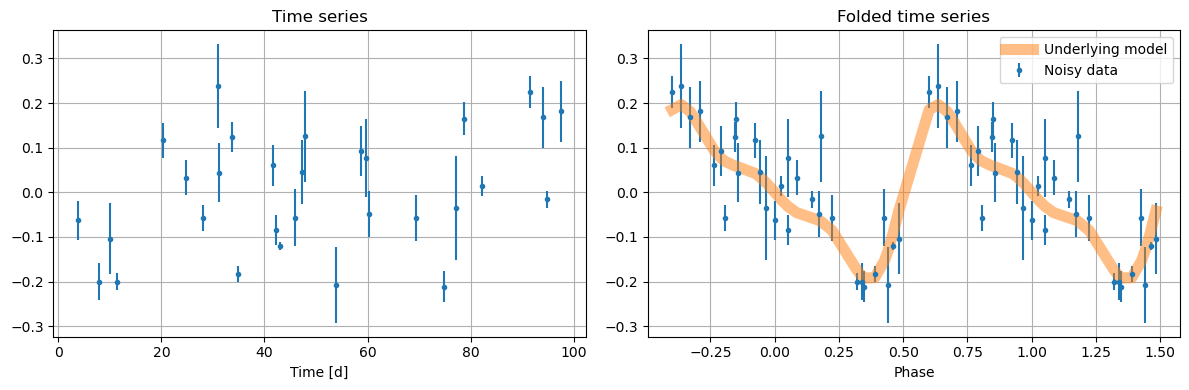

In [2]:
fundamental_freq = 2.0
lc_generator = P4J.synthetic_light_curve_generator(T=100.0, N=30, rseed=21)
lc_generator.set_model(f0=fundamental_freq, A=[1.0, 0.5, 0.25])
mjd, mag, err = lc_generator.draw_noisy_time_series(SNR=5.0, red_noise_ratio=0.25, outlier_ratio=0.0)
c_mjd, c_mag = lc_generator.get_clean_signal()

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.errorbar(mjd, mag, err, fmt='.')
ax.set_xlabel('Time [d]')
ax.set_title('Time series')
plt.grid()
ax = fig.add_subplot(1, 2, 2)
phase = np.mod(mjd, 1.0/fundamental_freq)*fundamental_freq
index = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]),
            np.concatenate([mag[index], mag[index]]),
            np.concatenate([err[index], err[index]]), fmt='.', alpha=1.0, label='Noisy data')
ax.plot(np.concatenate([np.sort(phase)-0.5, np.sort(phase)+0.5]),
        np.concatenate([c_mag[index], c_mag[index]]),
        linewidth=8, alpha=0.5, label='Underlying model')
plt.legend()
ax.set_xlabel('Phase')
ax.set_title('Folded time series')
plt.grid()
plt.tight_layout();

> The simulated data are sufficiently close to a real dataset with a modest number of heteroscedastic observations carried out when possible, i.e. irregularly during the "source" monitoring.

## Finding the best frequency/period using a Lomb-Scargle algorithm
***

- Before moving to non-parametric methods let's analyse our time-series with the standard algorithm for irregularly sampled time-series: the Lomb-Scargle (LS) algorithm.

- Let's remind us that for evenly sampled light-curves the LS reduces to the plain discrete Fourier transform.

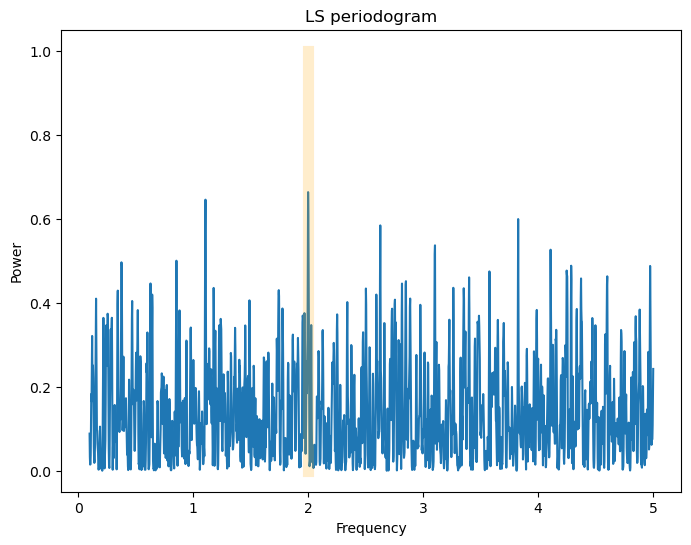

In [3]:
frequencyLS = np.linspace(0.1,5.,int(round(10000/5.)))
powerLS = LombScargle(mjd, mag, err).power(frequencyLS,normalization='standard')
best_frequency = frequencyLS[np.argmax(powerLS)]
#
p = plt.figure(figsize=(8,6))
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("LS periodogram")
plt.plot(frequencyLS,powerLS)
plt.plot([best_frequency, best_frequency], [0, 1], linewidth=8, alpha=0.2, color='orange');


- We see immediately that the LS periodogram indeed does show a peak at the expected frequency.
    - Yet, even without a detailed statistical analysis, it is clear that its significance, compared to the several other peaks of similar power (the scale is linear) should likely be modest.
    
> The LS periodogram in this rather typical (although, by no means, simple) case yields difficult to interpret results. We now move to non-parametric tools.

## Phase dispersion minimization (PDM)
***

- First, we try to apply one of the most widely knwon parametric method: the PDM.

- Of course, let's assumme that we do not know the best frequency for this time series. 

- To find it, we sweep over a linear array of frequencies and find the ones that optimize the selected criterion.   

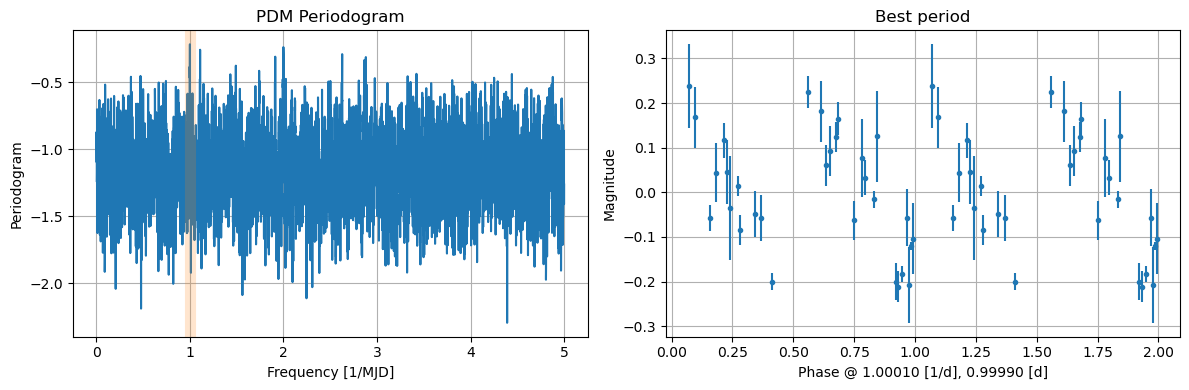

In [4]:
my_per = P4J.periodogram(method='PDM1') # Phase Dispersion Minimization

my_per.set_data(mjd, mag, err)
my_per.frequency_grid_evaluation(fmin=0.0, fmax=5.0, fresolution=1e-3)  # frequency sweep parameters
my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=10)
freq, per = my_per.get_periodogram()
fbest, pbest = my_per.get_best_frequencies() # Return best n_local_optima frequencies

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(freq, per)
ymin, ymax = ax.get_ylim()
ax.plot([fbest[0], fbest[0]], [ymin, ymax], linewidth=8, alpha=0.2)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/MJD]')
ax.set_ylabel('Periodogram')
plt.title('PDM Periodogram')
plt.grid()

ax = fig.add_subplot(1, 2, 2)
phase = np.mod(mjd, 1.0/fbest[0])*fbest[0]
idx = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase), np.sort(phase)+1.0]),
            np.concatenate([mag[idx], mag[idx]]),
            np.concatenate([err[idx], err[idx]]), fmt='.')
plt.title('Best period')
ax.set_xlabel('Phase @ %0.5f [1/d], %0.5f [d]' %(fbest[0], 1.0/fbest[0]))
ax.set_ylabel('Magnitude')
plt.grid()
plt.tight_layout();

- The PDM algorithm cannot recover the right input frequency as the highest peak in the periodogram.

- The situation is indeed analogius to what we saw for the LS periodogram. Several peaks of similar power are present making the interpretation of the periodogram difficult.


## Lafler-Kinman's string length
***

- This is one of the possible variants of string-length methods

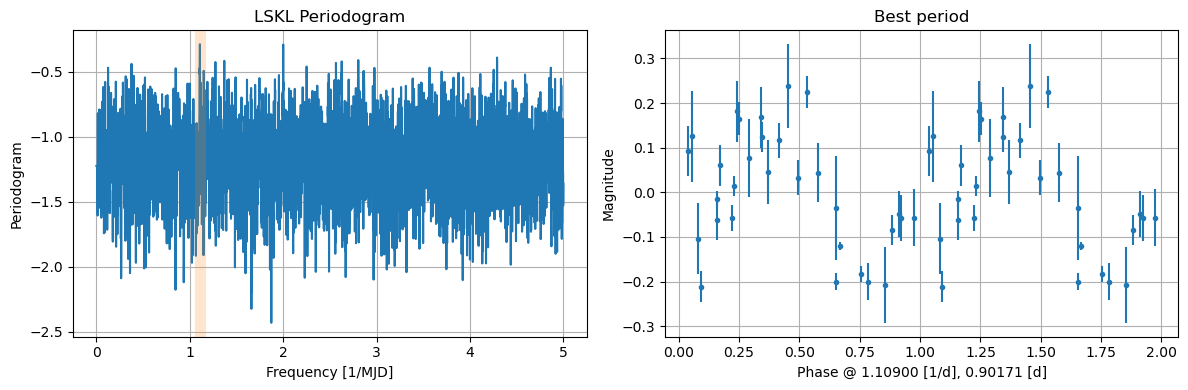

In [5]:
my_per = P4J.periodogram(method='LKSL') # Lafler-Kinman's string length

my_per.set_data(mjd, mag, err)
my_per.frequency_grid_evaluation(fmin=0.0, fmax=5.0, fresolution=1e-3)  # frequency sweep parameters
my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=10)
freq, per = my_per.get_periodogram()
fbest, pbest = my_per.get_best_frequencies() # Return best n_local_optima frequencies

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(freq, per)
ymin, ymax = ax.get_ylim()
ax.plot([fbest[0], fbest[0]], [ymin, ymax], linewidth=8, alpha=0.2)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/MJD]')
ax.set_ylabel('Periodogram')
plt.title('LSKL Periodogram')
plt.grid()

ax = fig.add_subplot(1, 2, 2)
phase = np.mod(mjd, 1.0/fbest[0])*fbest[0]
idx = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase), np.sort(phase)+1.0]),
            np.concatenate([mag[idx], mag[idx]]),
            np.concatenate([err[idx], err[idx]]), fmt='.')
plt.title('Best period')
ax.set_xlabel('Phase @ %0.5f [1/d], %0.5f [d]' %(fbest[0], 1.0/fbest[0]))
ax.set_ylabel('Magnitude')
plt.grid()
plt.tight_layout();

- Again, in spite of the fact that a peak at the right frequency is present, theere are several peaks of comparable power.

## AoV analysis
***

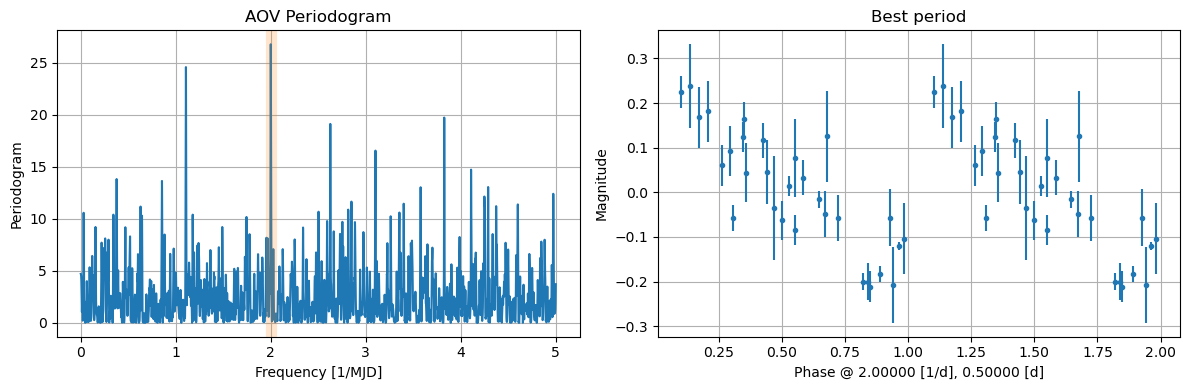

In [6]:
my_per = P4J.periodogram(method='MHAOV') # Multi-harmonic Analysis of Variance

my_per.set_data(mjd, mag, err)
my_per.frequency_grid_evaluation(fmin=0.0, fmax=5.0, fresolution=1e-3)  # frequency sweep parameters
my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=10)
freq, per = my_per.get_periodogram()
fbest, pbest = my_per.get_best_frequencies() # Return best n_local_optima frequencies

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(freq, per)
ymin, ymax = ax.get_ylim()
ax.plot([fbest[0], fbest[0]], [ymin, ymax], linewidth=8, alpha=0.2)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/MJD]')
ax.set_ylabel('Periodogram')
plt.title('AOV Periodogram')
plt.grid()

ax = fig.add_subplot(1, 2, 2)
phase = np.mod(mjd, 1.0/fbest[0])*fbest[0]
idx = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase), np.sort(phase)+1.0]),
            np.concatenate([mag[idx], mag[idx]]),
            np.concatenate([err[idx], err[idx]]), fmt='.')
plt.title('Best period')
ax.set_xlabel('Phase @ %0.5f [1/d], %0.5f [d]' %(fbest[0], 1.0/fbest[0]))
ax.set_ylabel('Magnitude')
plt.grid()
plt.tight_layout();

- Now the peak is at the right period, but there are several peaks os similar power.

## Finding the best frequency/period using P4J
***

Now let's assumme that we do not know the best frequency for this time series. To find it, we sweep over a linear array of frequencies and find the ones that optimize the selected criterion. In this case we recover the 10 local optima of the quadratic mutual information periodogram.  

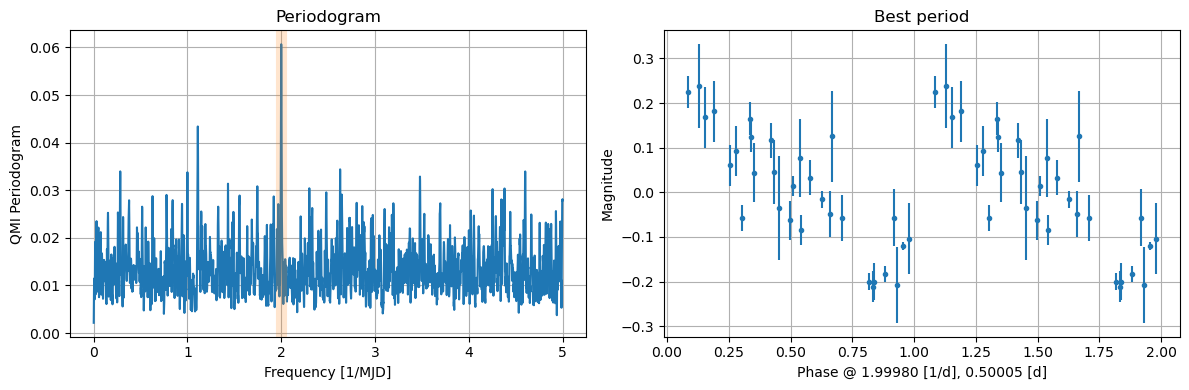

In [7]:
#my_per = P4J.periodogram(method='LKSL') # Lafler-Kinman's string length
#my_per = P4J.periodogram(method='PDM1') # Phase Dispersion Minimization
#my_per = P4J.periodogram(method='MHAOV') # Multi-harmonic Analysis of Variance
#my_per = P4J.periodogram(method='QME') # Quadratical mutual entropy or total correlation
#my_per = P4J.periodogram(method='QMICS') # Quadratic mutual information (QMI) based on Cauchy Schwarz distance
my_per = P4J.periodogram(method='QMIEU') # QMI based on Euclidean distance

my_per.set_data(mjd, mag, err)
my_per.frequency_grid_evaluation(fmin=0.0, fmax=5.0, fresolution=1e-3)  # frequency sweep parameters
my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=10)
freq, per = my_per.get_periodogram()
fbest, pbest = my_per.get_best_frequencies() # Return best n_local_optima frequencies

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(freq, per)
ymin, ymax = ax.get_ylim()
ax.plot([fbest[0], fbest[0]], [ymin, ymax], linewidth=8, alpha=0.2)
ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/MJD]')
ax.set_ylabel('QMI Periodogram')
plt.title('Periodogram')
plt.grid()

ax = fig.add_subplot(1, 2, 2)
phase = np.mod(mjd, 1.0/fbest[0])*fbest[0]
idx = np.argsort(phase)
ax.errorbar(np.concatenate([np.sort(phase), np.sort(phase)+1.0]),
            np.concatenate([mag[idx], mag[idx]]),
            np.concatenate([err[idx], err[idx]]), fmt='.')
plt.title('Best period')
ax.set_xlabel('Phase @ %0.5f [1/d], %0.5f [d]' %(fbest[0], 1.0/fbest[0]))
ax.set_ylabel('Magnitude')
plt.grid()
plt.tight_layout();

- This algorithm not only identfies the right frequency, but it is clearly producing a neat result with a dominant peak, compared to the rest of the periodogram, art the expected frequency.

## Significance of the detected period
***

- For a periodic time series with an oscillation frequency $f$, its periodogram will exhibit a peak at $f$ with high probability. 
    - But  the  inverse  is  not  necessarily  true,  a  peak in  the  periodogram  does  not  imply  that  the  time  series  is periodic.  Spurious  peaks  may  be  produced  by  measurement errors, random fluctuations, aliasing or noise.

- Among the various possibilities, we can test if the candidate frequencies (periodogram peaks) are statistically significant using bootstrap. 
    - This gives a principled way to test wheter the light curve is periodic or not. 
    - The core idea is to obtain the distribution of the maximum values of the periodogram on a set of surrogate light curves, obtained by random-resampling. 
    
- We can heuristically descrve the general procedure as follows:


- Assume, as the null hypothesis, that the light curve is not periodic.
    1. Generate surrogate light curves that comply with the null hypothesis.
    2. Compute the periodogram for each surrogate and save the maxima.
    3. Fit a extreme value probability density function (PDF) to the surrogate's maxima.
    4. For a given significance level (p-value) $\alpha$, i.e. the probability of rejecting the null hypothesis when it is actually true, obtain the associated confidence level from the fitted PDF.  
    5. If the candidate frequency has a periodogram value greater than the confidence level then you can reject the null hypothesis (for the selected $\alpha$).

In [8]:
# TODO: Create bootstrap class with iid bootstrap, moving block bootstrap, write proper documentation and debug this!
def block_bootstrap(mjd, mag, err, block_length=10.0, rseed=None):
    np.random.seed(rseed)
    N = len(mjd)
    mjd_boot = np.zeros(shape=(N, ))
    mag_boot = np.zeros(shape=(N, ))
    err_boot = np.zeros(shape=(N, ))
    k = 0
    last_time = 0.0
    for max_idx in range(2, N):
        if mjd[-1] - mjd[-max_idx] > block_length:
            break
    while k < N:
        idx_start = np.random.randint(N-max_idx-1)
        for idx_end in range(idx_start+1, N):
            if mjd[idx_end] - mjd[idx_start] > block_length or k + idx_end - idx_start >= N-1:
                break
        #print("%d %d %d %d" %(idx_start, idx_end, k, k + idx_end - idx_start))
        mjd_boot[k:k+idx_end-idx_start] = mjd[idx_start:idx_end] - mjd[idx_start] + last_time
        mag_boot[k:k+idx_end-idx_start] = mag[idx_start:idx_end]
        err_boot[k:k+idx_end-idx_start] = err[idx_start:idx_end]
        last_time = mjd[idx_end] - mjd[idx_start] + last_time
        k += idx_end - idx_start
    return mjd_boot, mag_boot, err_boot

In [9]:
# We will use 200 surrogates and save 20 local maxima per light curve
pbest_bootstrap = np.zeros(shape=(200, 20))
for i in range(pbest_bootstrap.shape[0]):
    # P = np.random.permutation(len(mjd))
    # my_per.set_data(mjd, mag[P], err[P])  # IID bootstrap
    mjd_b, mag_b, err_b = block_bootstrap(mjd, mag, err, block_length=0.9973)
    my_per.set_data(mjd_b, mag_b, err_b)
    my_per.frequency_grid_evaluation(fmin=0.0, fmax=4.0, fresolution=1e-3)
    my_per.finetune_best_frequencies(fresolution=1e-4, n_local_optima=pbest_bootstrap.shape[1])
    _, pbest_bootstrap[i, :] = my_per.get_best_frequencies()

## Generalized extreme value distribution
***

- As for any Monte Carlo method, we need to run a sufficiently large number of simulated events (i.e., light curves) to allow a well defined inference.

- Let'assume, for instance, that we run 100 simulations and discover that the power measured from the periodogram obtained by the real data is, say, at a level wehere $\sim 20$\% of simulated periodograms show a higher power. 
    - This clearly indicates we cannot reject the null-hypotesis.
    
- However, it might also happens that the power from the real periodogram is higher than $99$\% of the simulated power. Now, with just 100 simulations we are in a situation where detailed evalutation of the false alarm probability is dominated by low.statistics, and we need to run more simulations, probaly a thousands or so.

- In any case, if we need to sample accurately the extreme tail of the distribution we quickly need to increase the number of simulations and this might well become a bottle-neck for the whole procedure.

- This problem has been addressed by [S&uuml;veges (2014)](https://ui.adsabs.harvard.edu/abs/2014MNRAS.440.2099S/abstract). The abstract of the paper readds:

*I propose a new procedure to estimate the false alarm probability, the measure of significance for peaks of periodograms. The key element of the new procedure is the use of generalized extreme-value distributions, the limiting distribution for maxima of variables from most continuous distributions. This technique allows reliable extrapolation to the very high probability levels required by multiple hypothesis testing, and enables the derivation of confidence intervals for the estimated levels. [...]*

### The algorithm
***

- The idea behind the use of the [Generalized extreme distribution (GED)](https://en.wikipedia.org/wiki/Generalized_extreme_value_distribution) is relatively simple.

- The general principles of the detection are those of statistical hypothesis testing and model selection. A null hypothesis $H_0$ of no periodic signal in the observed time series is tested against the alternative of the presence of a periodic deterministic component.

- The alternative hypothesis is formalized by a series of more complex models $M_f$ indexed by thefrequency $f$, consisting of a periodic signal at $f$ and noise. 

- Both the null model $M_0$ and the collection $M_f$ are fitted to the data, and a test statistic $\Theta(f)$ is computed for all models, which quantifies the improvement yielded by $M_f$ over $M_0$. 
    - This collection of test statistics as a function of $f$ is called the periodogram. 
    
- The frequency at which the largest improvement is achieved is accepted as the most likely frequency of a potential periodic component. Then the decision, whether the object shows a periodic oscillation or not, is based on the significance assessment of the model improvement: the probability is computed that the found periodogram maximum or a higher value is produced under the null hypothesis. This probability is termed the false alarm probability (FAP).

- This assessment is a multiple testing situation: as we do not know the frequency of the sought oscillation in advance, we compute the test statistic often at hundreds of thousands of frequencies. 
    - Thus, the single-value distribution $F$ (the marginal distribution) of the individual test statistics is not directly applicable to compute the FAP. Instead, we must find the distribution $G$ of the maximum of a large set of test statistics.
    
- The idea which is most commonly used in astronomy to obtain $G$ and the FAP is based on elementary probability calculations for the maxima of $M$ independent variables with common distribution function $F$, yielding the formula $G(z) = F(z)^M$. 
    - We have seen this discussion when we introduced the discrete Fourier transform and Lomb_scargle periosdograms and their statistics.

- In spite ot its simplicity, there are several issues in practical applications. The form $F(z)^M$ requires an estimate of $M$, often called the number of independent frequencies in the periodogram, which is time-consuming to produce, and needs a good knowledge about the marginal distribution $F$ of the periodogram.

- In order to avoid the shortcomings of the formula $F(z)^M$ it is proposed to apply the extreme-value statistics.

- Statistical theory proved that a suitable regularization of the observed maxima leads to a simple three-parameter limiting distribution, called the generalized extreme-value family (GEV) that provides a regular approximation to the distribution of maxima of random variables, similarly to the central limit theorem for the sum or the mean of a collection of random variables. 
    - The validity range of this limit theorem is very broad: it encompasses practically all continuous distributions and dependent variables too, under some mild conditions.
    
- The procedure proposed here fits a GEV model to the tail of the distribution of the periodogram under the null hypothesis that the time series is white noise.

$$ G(z) = Pr\{Z_{\rm max,n} \le z\} = \exp\{ -(1+\xi \frac{z-\mu}{\sigma})^{-1/\xi} \} $$

where $z$ is such that $1+\xi(z-\mu)/\sigma > 0$. If $\xi \rightarrow 0$ the distribution is known as [Gumbel distribution](https://en.wikipedia.org/wiki/Gumbel_distribution).

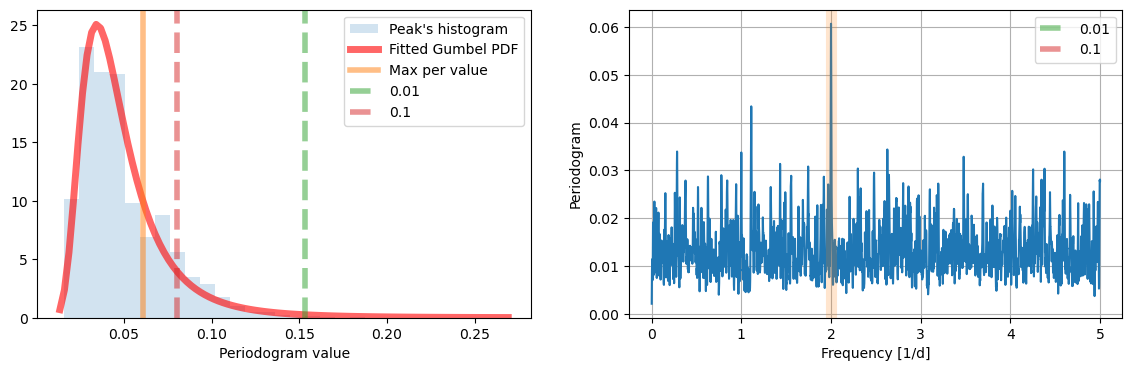

In [10]:
#from scipy.stats import  gumbel_r  # Gumbel right (for maxima), its has 2 parameters
from scipy.stats import  genextreme  # Generalized extreme value distribution, it has 3 parameters

param = genextreme.fit(pbest_bootstrap.ravel())
rv = genextreme(c=param[0], loc=param[1], scale=param[2])
x = np.linspace(rv.ppf(0.001), rv.ppf(0.999), 100)
fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(1, 2, 1)
_ = ax.hist(pbest_bootstrap.ravel(), bins=20, density=True, alpha=0.2, label='Peak\'s histogram')
ax.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='Fitted Gumbel PDF')
ymin, ymax = ax.get_ylim()
ax.plot([pbest[0], pbest[0]], [ymin, ymax], '-', linewidth=4, alpha=0.5, label="Max per value")
for p_val in [1e-2, 1e-1]:
    ax.plot([rv.ppf(1.-p_val), rv.ppf(1.-p_val)], [ymin, ymax], '--', linewidth=4, alpha=0.5, label=str(p_val))
ax.set_ylim([ymin, ymax])
plt.xlabel('Periodogram value'); plt.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(freq, per)
ymin, ymax = ax.get_ylim()
ax.plot([fbest[0], fbest[0]], [ymin, ymax], '-', linewidth=8, alpha=0.2)
# Print confidence bars
xmin, xmax = ax.get_xlim()
for p_val in [1e-2, 1e-1]:
    ax.plot([xmin, xmax], [rv.ppf(1.-p_val), rv.ppf(1.-p_val)], '--', linewidth=4, alpha=0.5, label=str(p_val))
ax.set_xlim([xmin, xmax]); ax.set_ylim([ymin, ymax])
ax.set_xlabel('Frequency [1/d]'); ax.set_ylabel('Periodogram')
plt.grid(); plt.legend();

### Notes
***

- In this example we used the the generalized extreme value (GEV) distribution to fit the periodogram peaks. The number of surrogates and amount of local maxima per surrogate should be set so that the fit looks good.

- In IID bootstrap the data points are randomly sampled with replacement. The IID bootstrap destroys not only the periodicity but also any time correlation or structure in the time series. This results in underestimation of the confidence bars. 
    - For data with serial correlations it is better to use moving block (MB) bootstrap. In MB bootstrap blocks of data of a given length are patched together to create a new time series. The block length is a parameter. Because light curves are irregularly sampled we set a block length in days rather than number of points. The ideal is to set the length so that it destroys the periodicity and preserves most of the serial correlation

- Bootstrap applied to time series is discussed in [Bühlmann (2002) - "Bootstraps for time series."](https://www.jstor.org/stable/3182810?casa_token=fuWC-ffm10sAAAAA%3A2PyzOtU2pxoXzaTaaYIaWjrCA3nokR5BjvLdggYcci8Rn8G7UPz4ceMEXfuDOOHg1NtuVWO6ZMkXUjwJl5pLcKxt1ojZTK9WpgrjJPdGsE6o83LjNcuG).

## Reference & Material
***

Material and papers related to the topics discussed in this lecture.

- [S&uuml;veges (2014) - "Extreme-value modelling for the significance assessment of periodogram peaks"](https://ui.adsabs.harvard.edu/abs/2014MNRAS.440.2099S/abstract). 

### Credits
***

*This notebook is obtained and further elaborated from: https://github.com/phuijse/P4J/tree/master/examples*

## Course Flow
***

<table>
  <tr>
    <td>Previous lecture</td>
    <td>Next lecture</td>
  </tr>
  <tr>
    <td><a href="../Lecture%20-%20Non%20Parametric%20Analysis/Lecture-NonParametricAnalysis.ipynb">Lecture about non-parametric analysis</a></td>
    <td><a href="../Lecture%20-%20Gaussian%20Processes/Lecture-GassianProcesses.ipynb">Lecture about Gaussian processes</a></td>
  </tr>
 </table>


**Copyright**
***

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the examples, unless obtained from other properly quoted sources, under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Stefano Covino, Time Domain Astrophysics - Lecture notes featuring computational examples, 2024*.